# Sentiment analysis using Transformer - RoBERTa (kind of BERT model)

Link of dataset :- https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial


In this notebook we will do sentiment analysis in 2 ways:-

1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach

2. Roberta Pretrained Model from hugging face

3. Hugging face pipeline

## Read in Data and NLTK basics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
 98% 238M/242M [00:06<00:00, 42.8MB/s]
100% 242M/242M [00:07<00:00, 36.1MB/s]


In [4]:
# it will download the zip file so we will up zip it
import zipfile
zip_ref = zipfile.ZipFile('/content/amazon-fine-food-reviews.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
#Read in Data
df = pd.read_csv('Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [6]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


##Quick EDA

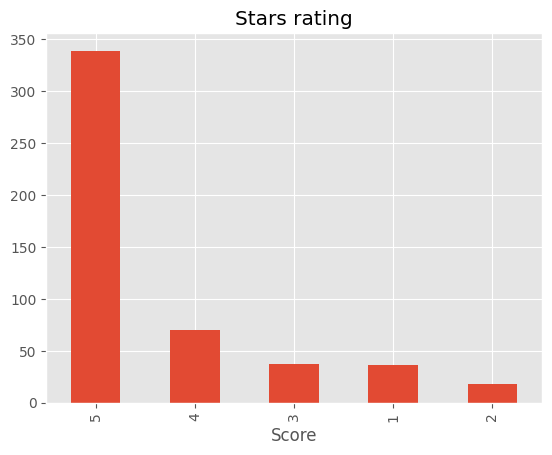

In [7]:
ax = df['Score'].value_counts().plot(kind = 'bar', title = 'Stars rating')

## Basic NLTK

In [8]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [9]:
nltk.download('punkt')
tokens = nltk.word_tokenize(example)
tokens[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [10]:
nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [11]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## 1. VADER sentiment scoring
It's an algorithm

We will use NLTK SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.


This uses a "bag of words" approach:-

Stop words are removed

each word is scored and combined to a total score.

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [13]:
sia.polarity_scores('I am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [14]:
sia.polarity_scores('This is worst thing ever')

{'neg': 0.506, 'neu': 0.494, 'pos': 0.0, 'compound': -0.6249}

In [15]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [16]:
# run polarity scores on entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
  text = row['Text']
  myid = row['Id']
  res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index':'Id'})
vaders = vaders.merge(df, how = 'left')

In [18]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# WHY Vaders

for interview read this :- https://www.bairesdev.com/blog/best-python-sentiment-analysis-libraries/

## Plotting VADERS result

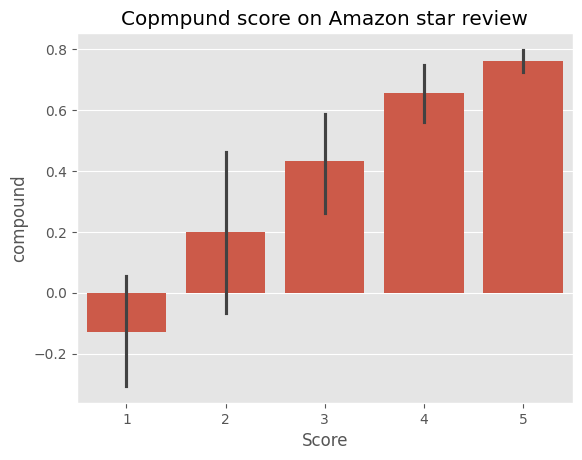

In [19]:
ax = sns.barplot(data = vaders, x = 'Score', y = 'compound')
ax.set_title('Copmpund score on Amazon star review')
plt.show()

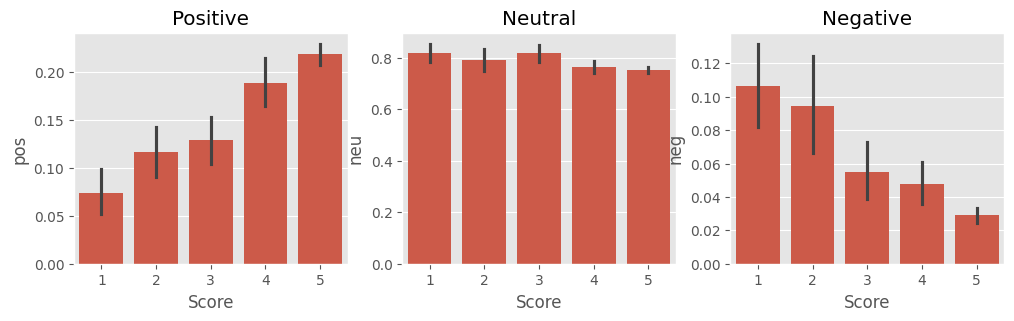

In [20]:
fig, axs = plt.subplots(1, 3, figsize = (12, 3))
sns.barplot(data = vaders, x = 'Score', y = 'pos', ax = axs[0])
sns.barplot(data = vaders, x = 'Score', y = 'neu', ax = axs[1])
sns.barplot(data = vaders, x = 'Score', y = 'neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

# Step 3 - Roberta pretrained model

In [21]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [22]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [23]:
# vader results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [24]:
# running the Roberta Model
encoded_text = tokenizer(example, return_tensors = 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [25]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors = 'pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
      'roberta_neg' : scores[0],
      'roberta_neu' : scores[1],
      'roberta_pos' : scores[2]
      }
  print(scores_dict)

In [26]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}
        roberta_result = polarity_scores_roberta(text)

        if roberta_result is None:
            roberta_result = {'roberta_neg': 0, 'roberta_neu': 0, 'roberta_pos': 0}  # Default values

        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

{'roberta_neg': 0.009624235, 'roberta_neu': 0.049980413, 'roberta_pos': 0.94039536}
{'roberta_neg': 0.508986, 'roberta_neu': 0.4524136, 'roberta_pos': 0.038600393}
{'roberta_neg': 0.0032289, 'roberta_neu': 0.09806747, 'roberta_pos': 0.8987037}
{'roberta_neg': 0.0022951297, 'roberta_neu': 0.09021926, 'roberta_pos': 0.9074856}
{'roberta_neg': 0.0016347283, 'roberta_neu': 0.0103024645, 'roberta_pos': 0.98806286}
{'roberta_neg': 0.006129596, 'roberta_neu': 0.021795876, 'roberta_pos': 0.97207457}
{'roberta_neg': 0.0013047534, 'roberta_neu': 0.0077737905, 'roberta_pos': 0.99092144}
{'roberta_neg': 0.002029358, 'roberta_neu': 0.005685204, 'roberta_pos': 0.9922854}
{'roberta_neg': 0.0038735769, 'roberta_neu': 0.09415625, 'roberta_pos': 0.9019702}
{'roberta_neg': 0.0031034583, 'roberta_neu': 0.05591222, 'roberta_pos': 0.9409843}
{'roberta_neg': 0.019134127, 'roberta_neu': 0.0710445, 'roberta_pos': 0.9098214}
{'roberta_neg': 0.37264356, 'roberta_neu': 0.51969886, 'roberta_pos': 0.10765766}
{'rob

In [27]:
## This code is to check the sentence of row 83 and 187 which broke - reaseach why it broke

# Assuming 'df' is your DataFrame and 'Id' is the column name
specific_id = 83

# Filter the DataFrame for the row with Id 83
row = df[df['Id'] == specific_id]

# Check if the row exists
if not row.empty:
    # Get the text for the specific row
    text = row['Text'].values[0]
    print(f"Text for Id {specific_id}: {text}")
else:
    print(f"No row found with Id {specific_id}")

Text for Id 83: I know the product title says Molecular Gastronomy, but don't let that scare you off.  I have been looking for this for a while now, not for food science, but for something more down to earth.  I use it to make my own coffee creamer.<br /><br />I have to have my coffee blonde and sweet - but the flavored creamers are full of the bad kinds of fat, and honestly, I hate to use manufactured "food" items.  I really don't think they are good for the body.  On the other hand, I hate using cold milk or cream, because I like HOT coffee.<br /><br />I stumbled across this on Amazon one day and got the idea of making my own creamer.  I also bought low-fat (non-instant) milk powder and regular milk powder. The non-instant lowfat milk is a little sweeter and tastes fresher than regular instant low-fat milk, but does not dissolve good in cold water - which is not a problem for hot coffee.  You will have to play with the ratios - I would not do just the heavy cream, it made the coffee 

In [28]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index':'Id'})
results_df = results_df.merge(df, how = 'left')

## Compare scores between models

In [29]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [30]:
results_df.head(2)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.0,0.0,0.0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.0,0.0,0.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


# 3.Combine and Compare

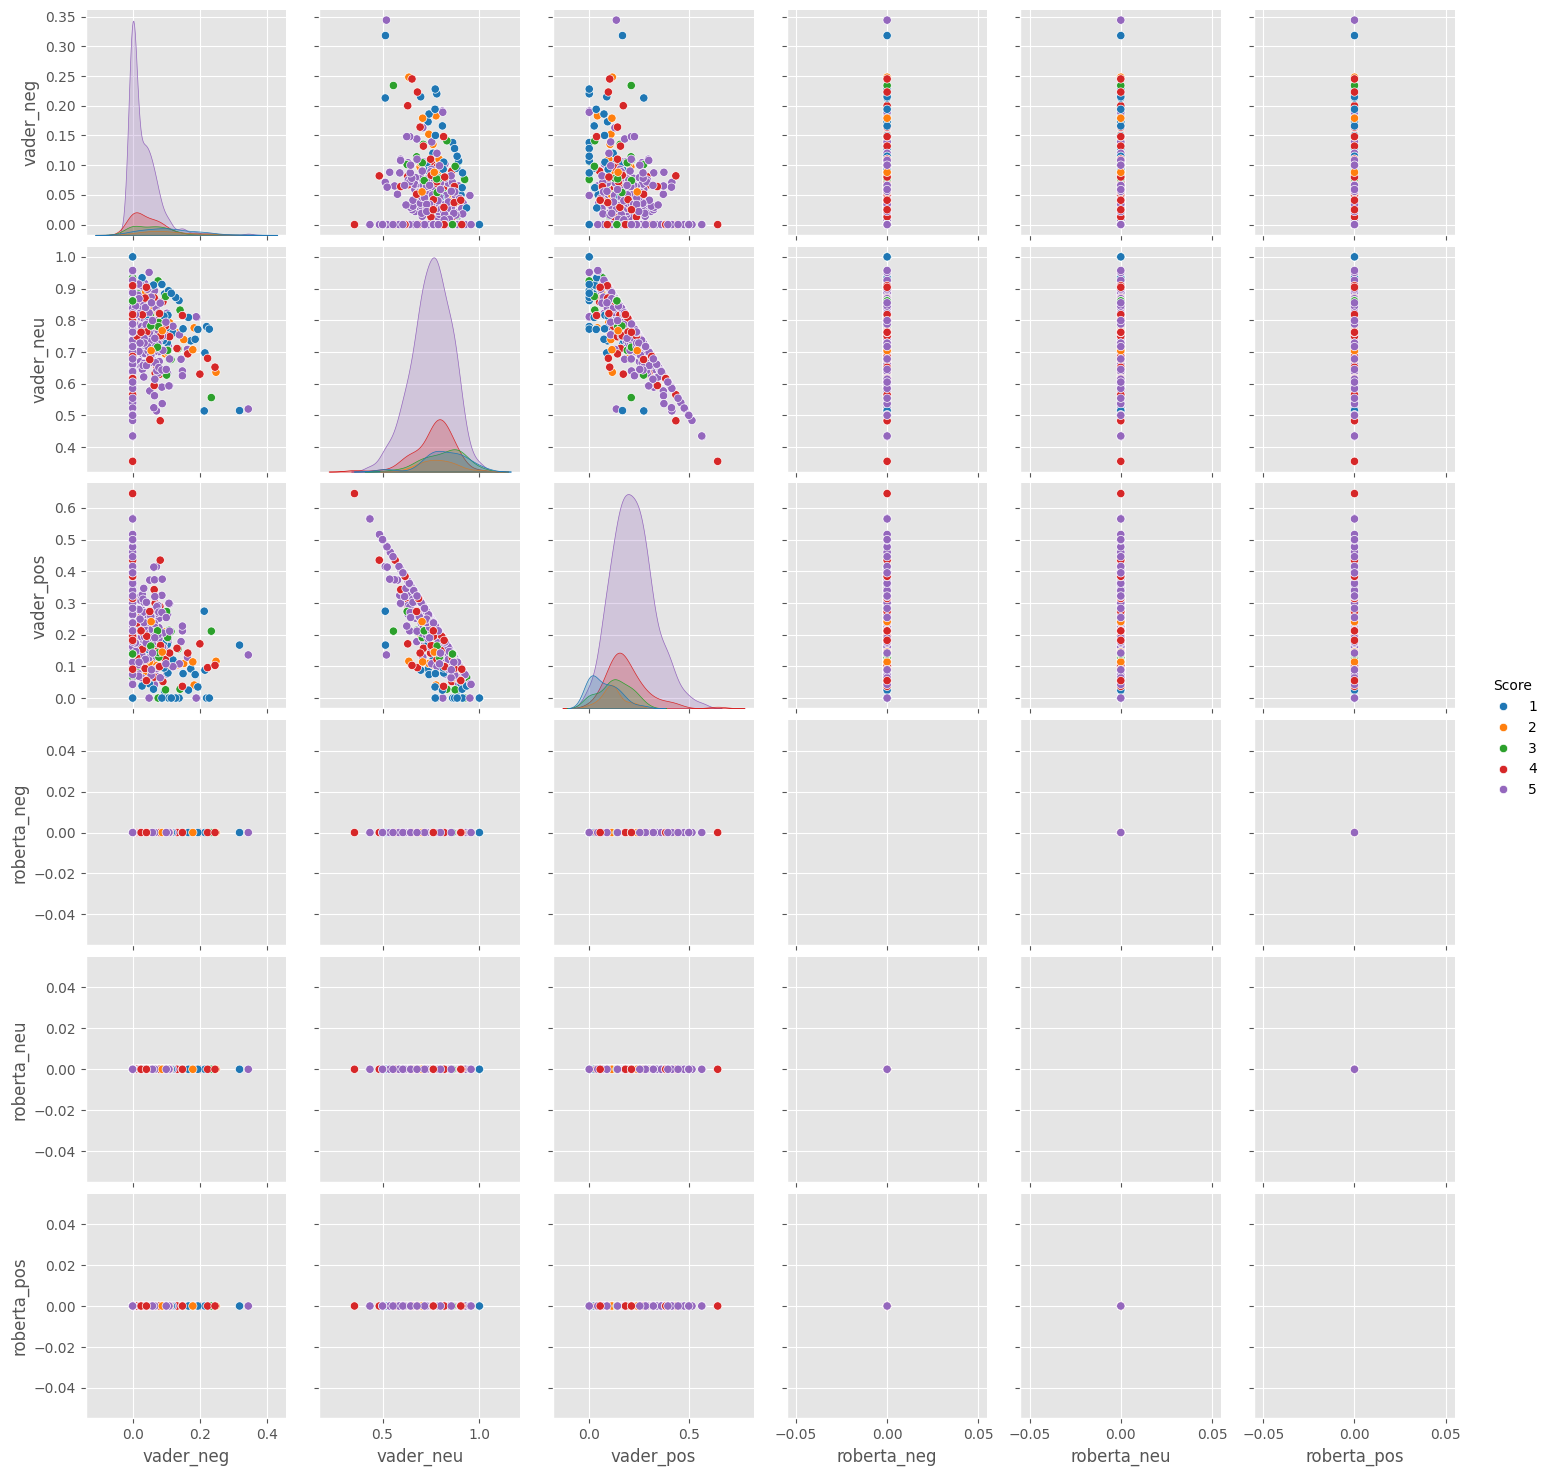

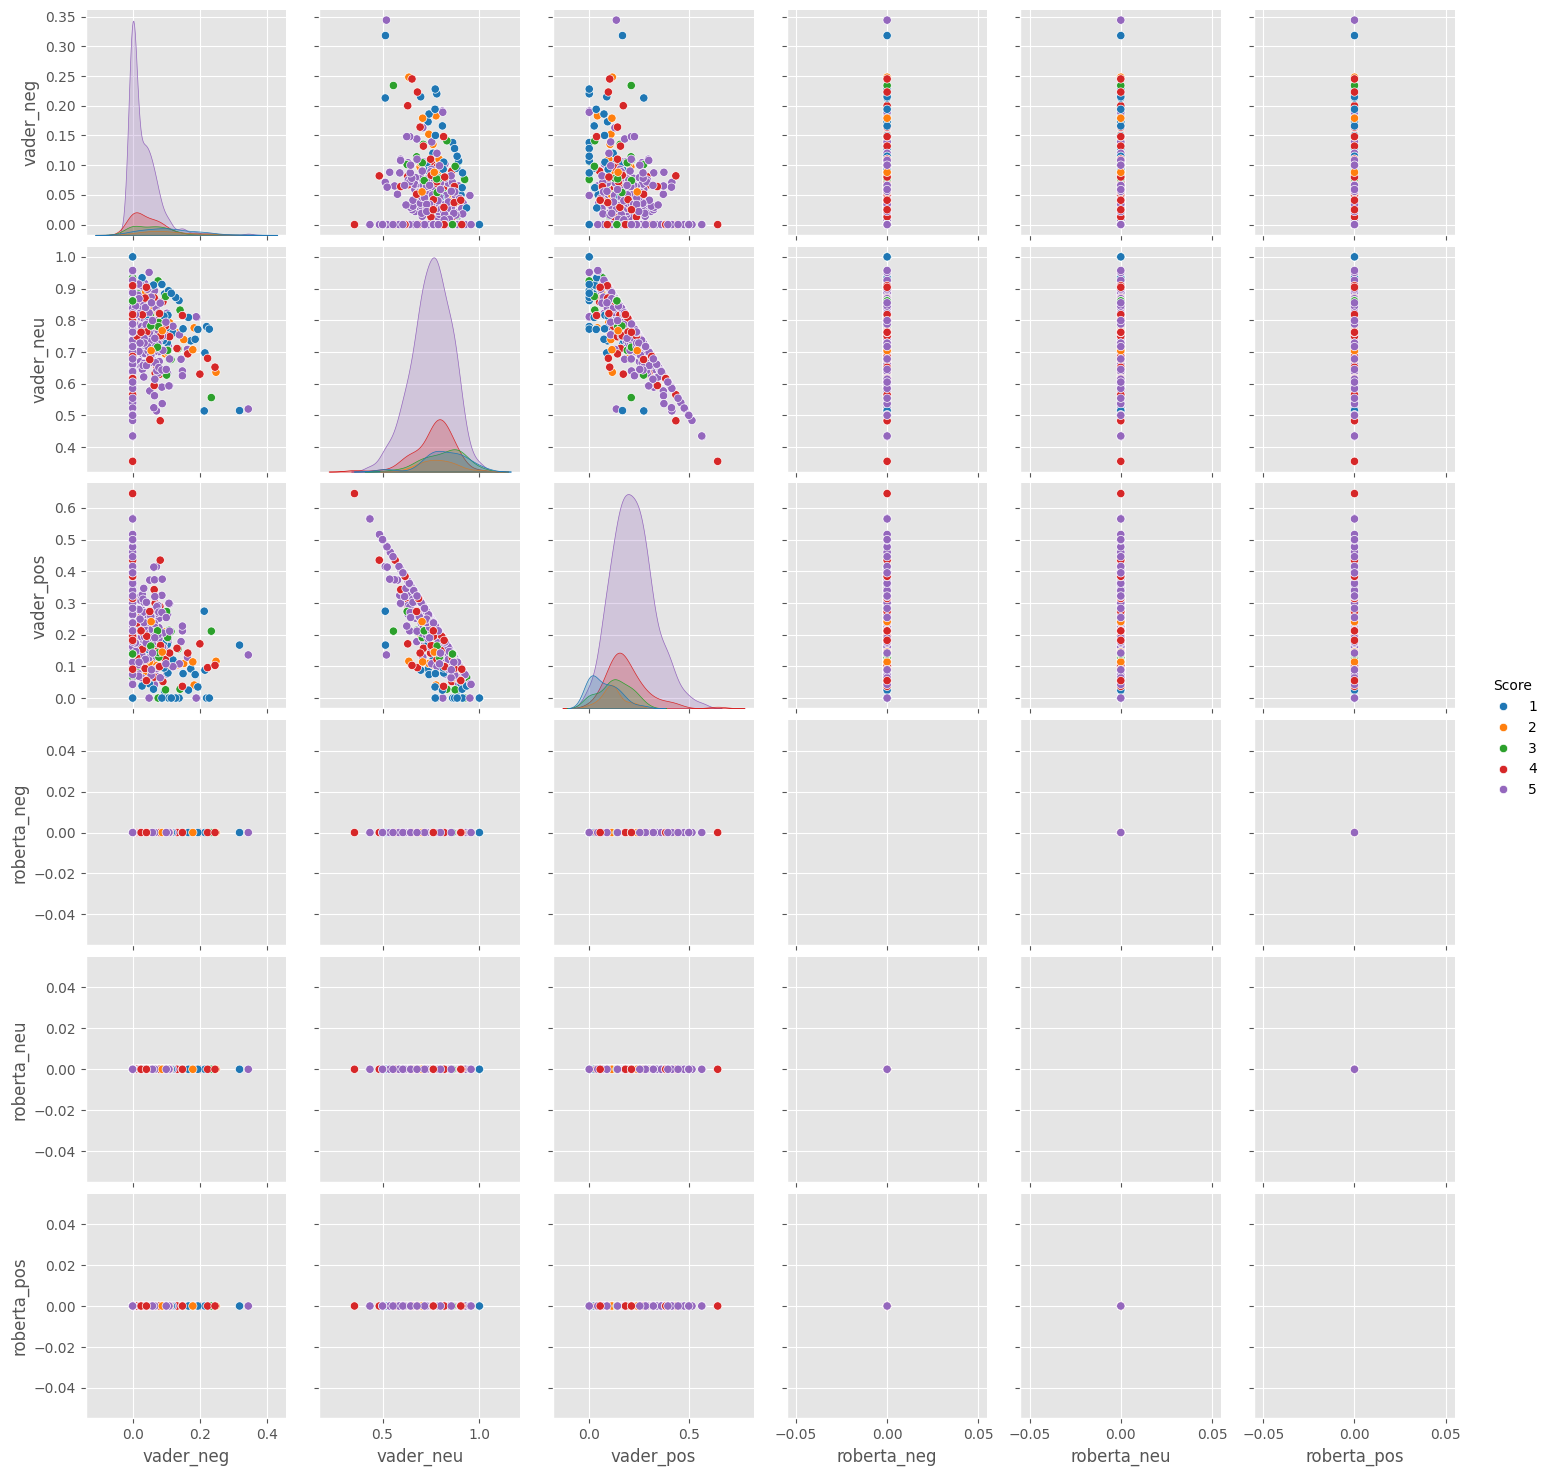

In [31]:
sns.pairplot(data = results_df,
             vars = ['vader_neg', 'vader_neu', 'vader_pos',
                     'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue = 'Score',
             palette = 'tab10')
plt.show()

#Step 4. Review example

Positive 1 star and Negative 5-star reviews

Lets look at some examples where the model scoring and review score differ the most.

In [34]:
results_df.query('Score == 1') \
.sort_values('roberta_pos', ascending = False)['Text'].values[0]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

In [36]:
results_df.query('Score == 1') \
.sort_values('vader_pos', ascending = False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [38]:
# Negatie sentence 5 star review
results_df.query('Score == 5') \
.sort_values('roberta_neg', ascending = False)['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [39]:
results_df.query('Score == 5') \
.sort_values('vader_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# Extra : The Transformer Pipeline

In [40]:
from transformers import pipeline
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [41]:
# pipeline is ready we can test it now
sent_pipeline('I love the product')

[{'label': 'POSITIVE', 'score': 0.999872088432312}]

In [42]:
sent_pipeline('This place is awful')

[{'label': 'NEGATIVE', 'score': 0.9997410178184509}]

In [44]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

# The END